## Scikit-learn Model Sandbox

### Build a classifier model

Now the fun begins. We have a large dataframe of features with some of the rows labelled. We will only train a model with labelled data, so the first step will be to select a subset of the dataframe which has a positive label (1-9). The negative labels indicate the event is unlabelled, they will not be useful for training.

scikit-learn is a excellent python package to try different classical machine learning techniques. Our dataset of ~20000 labels fits this domain well.

Ideas that might be useful:

* Select a small subset of features and train a simple model (SVM, decision tree, KNN) to set a base case to a model
* Normalize the features
* Preform a dimensionality reduction step

### Labels

#### RFI

* 1 : Unclipped RFI/Noise
* 2 : Wide-band, long-duration in time clipped RFI (2016+)
* 3 : Wide-band, short-duration in time clipped RFI (2016+)
* 4 : Wide-band, short duration clipped RFI (2015)
* 5 : Sharp bandpass transition
* 6 : Wide-band, bursty clipped RFI (2015)
* 7 : Error in spectra captue or replacement
* 8 : Systematic int/float overflow

#### Astronomical

* 0 : Interesting, follow up
* 9 : Known Pulsar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Preamble

Read in the dataframe and prepare the features for use in scikit-learn.

In [2]:
pd.__version__

u'0.20.2'

In [3]:
df = pd.read_pickle('featureDataframe.pkl')

In [4]:
df.describe()

,Beam,Buffer,MJDstart,bestDM,bestSNR,BinFactor,Events,DMmax,DMmin,DMmean,...,pixelMean_15_0,pixelMax_15_1,pixelMin_15_1,pixelMean_15_1,pixelMax_15_2,pixelMin_15_2,pixelMean_15_2,pixelMax_15_3,pixelMin_15_3,pixelMean_15_3
count,73282.000000,73282.000000,73282.000000,73282.000000,73282.000000,73282.000000,7.328200e+04,73282.000000,73282.000000,73282.000000,...,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04
mean,3.556617,211.437952,57392.275750,994.132829,12.890546,14.171406,5.290837e+03,1843.879770,355.848537,1106.626399,...,3.036053e+38,3.663497e+38,3.663497e+38,3.663497e+38,3.122199e+38,3.122199e+38,3.122199e+38,2.912765e+38,2.912765e+38,2.912765e+38
std,2.433997,272.753575,186.092812,2270.499049,79.265038,20.233713,3.448143e+04,3329.930528,1195.291547,2135.608269,...,1.204643e+39,1.308466e+39,1.308466e+39,1.308466e+39,1.157410e+39,1.157410e+39,1.157410e+39,1.196846e+39,1.196846e+39,1.196846e+39
min,0.000000,1.000000,57197.378446,0.000000,6.001704,1.000000,1.000000e+00,3.000000,0.000000,3.000000,...,-8.851245e+04,-1.229460e+05,-1.229460e+05,-1.229460e+05,-1.541351e+05,-1.541351e+05,-1.541351e+05,-1.649856e+05,-1.649856e+05,-1.649856e+05
25%,1.000000,25.000000,57275.173537,7.000000,10.510364,2.000000,4.000000e+00,10.000000,5.000000,7.500000,...,-1.281110e+01,1.217415e+01,1.217415e+01,1.217415e+01,1.911395e+01,1.911395e+01,1.911395e+01,2.122114e+01,2.122114e+01,2.122114e+01
50%,4.000000,111.000000,57328.330289,13.000000,11.301913,4.000000,3.400000e+01,27.000000,7.000000,16.500000,...,3.136781e+00,2.029442e+01,2.029442e+01,2.029442e+01,3.726743e+01,3.726743e+01,3.726743e+01,4.588743e+01,4.588743e+01,4.588743e+01
75%,6.000000,295.000000,57372.219326,273.000000,12.641252,16.000000,4.890000e+02,2024.000000,16.000000,947.812319,...,3.046355e+01,3.833758e+01,3.833758e+01,3.833758e+01,6.726700e+01,6.726700e+01,6.726700e+01,8.036246e+01,8.036246e+01,8.036246e+01
max,6.000000,2001.000000,57893.840891,10039.000000,20954.304688,64.000000,2.135578e+06,57287.182376,10035.000000,10035.500000,...,1.956399e+40,2.133469e+40,2.133469e+40,2.133469e+40,2.055277e+40,2.055277e+40,2.055277e+40,2.146130e+40,2.146130e+40,2.146130e+40


In [5]:
df.shape

(73282, 406)

#### Re-label Mis-labelled Type 8 Events

In [6]:
reLabel = [('Beam4_fb_D20150821T195709.fil', 202),
           ('Beam0_fb_D20150906T194609.fil', 275),
           ('Beam4_fb_D20150909T235709.fil', 467),
           ('Beam6_fb_D20150925T221909.fil', 3),
           ('Beam1_fb_D20151215T221703.fil', 377),
           ('Beam1_fb_D20151215T221703.fil', 595),
           ('Beam1_fb_D20151216T231103.fil', 50),
           ('Beam1_fb_D20151217T050412.fil', 196),
           ('Beam1_fb_D20151217T050412.fil', 197),
           ('Beam1_fb_D20151217T050412.fil', 202),
           ('Beam0_fb_D20160824T104004.fil', 1392),
           ('Beam0_fb_D20160825T003010.fil', 3),
           ('Beam0_fb_D20160824T104004.fil', 1392),
           ('Beam0_fb_D20160825T003010.fil', 3),
           ('Beam0_fb_D20170310T020409.fil', 6),
           ('Beam0_fb_D20170310T020409.fil', 8),
           ('Beam0_fb_D20170310T020409.fil', 9),
           ('Beam0_fb_D20170310T020409.fil', 11),
           ('Beam0_fb_D20170310T020409.fil', 14),
           ('Beam0_fb_D20170310T020409.fil', 15),
           ('Beam0_fb_D20170310T020409.fil', 16),
           ('Beam0_fb_D20170310T020409.fil', 17),
           ('Beam0_fb_D20170310T020409.fil', 19),
           ('Beam0_fb_D20170310T020409.fil', 21),
           ('Beam0_fb_D20170310T020409.fil', 25),
           ('Beam1_fb_D20170310T020409.fil', 4),
           ('Beam4_fb_D20170310T020409.fil', 7),
           ('Beam5_fb_D20170310T020409.fil', 1),
           ('Beam5_fb_D20170310T020409.fil', 2),
           ('Beam6_fb_D20170311T184903.fil', 2),
           ('Beam1_fb_D20170312T182504.fil', 2),
           ('Beam2_fb_D20170325T011509.fil', 1),
           ('Beam1_fb_D20170310T020409.fil', 3),
           ('Beam0_fb_D20170311T184903.fil', 2),
           ('Beam1_fb_D20170311T184903.fil', 1),
           ('Beam5_fb_D20170312T182504.fil', 1),
           ('Beam1_fb_D20170310T020409.fil', 2),
           ('Beam6_fb_D20170311T184903.fil', 3),
           ('Beam4_fb_D20170312T182504.fil', 10),
           ('Beam0_fb_D20170310T020409.fil', 2),
           ('Beam4_fb_D20170310T020409.fil', 4),
           ('Beam0_fb_D20170310T020409.fil', 1),
           ('Beam0_fb_D20170310T020409.fil', 3),
           ('Beam0_fb_D20170310T020409.fil', 4),
           ('Beam0_fb_D20170310T020409.fil', 5),
           ('Beam0_fb_D20170310T020409.fil', 7),
           ('Beam0_fb_D20170310T020409.fil', 10),
           ('Beam0_fb_D20170310T020409.fil', 12),
           ('Beam0_fb_D20170310T020409.fil', 13),
           ('Beam0_fb_D20170310T020409.fil', 18),
           ('Beam0_fb_D20170310T020409.fil', 20),
           ('Beam0_fb_D20170310T020409.fil', 22),
           ('Beam0_fb_D20170310T020409.fil', 23),
           ('Beam0_fb_D20170310T020409.fil', 24),
           ('Beam1_fb_D20170310T020409.fil', 1),
           ('Beam4_fb_D20170310T020409.fil', 3),
           ('Beam4_fb_D20170310T020409.fil', 5),
           ('Beam4_fb_D20170310T020409.fil', 6),
           ('Beam0_fb_D20170311T184903.fil', 1)]

In [7]:
# Relabel mis-labelled events to overflow (label 8)
for fil,buf in reLabel:
    #print fil, buf
    df.loc[(df['filterbank']==fil) & (df['Buffer']==buf), 'Label'] = 8

#### Compute MJD Features

In [8]:
df['relMJDmax'] = df['MJDmax'] - df['MJDmin']
df['relMJDmean'] = df['MJDmean'] - df['MJDmin']
df['relMJDmedian'] = df['MJDmedian'] - df['MJDmin']

**Filter for only labelled data (i.e. Label > -1) and Drop Type 8 Events**

In [9]:
labelledDf = df[df['Label'] > -1]
labelledDf = labelledDf[labelledDf['Label'] != 8]

In [10]:
for col in labelledDf:
    print col, labelledDf[col].max(), labelledDf[col].min()

datfile Beam6_dm_D20170324T215304.dat Beam0_dm_D20150624T020452.dat
Beam 6 0
TSID D20170325T092403 D20150624T020452
Buffer 2001 1
MJDstart 57837.3807827 57197.3846557
bestDM 10039.0 51.0
bestSNR 1256.84655762 10.0002756119
BinFactor 64 1
Events 1800508 1
DMmax 10039.0 54.0
DMmin 10035.0 0.0
DMmean 10035.5 25.1612903226
DMmedian 10035.5 9.0
DMstd 4672.49363237 0.707106781187
SNRmean 483.575054976 6.81363773894
SNRmedian 431.750549316 6.55111432075
SNRstd 353.681043422 0.000775502012695
MJDmax 57837.3808056 57197.3847504
MJDmin 57837.3808055 57197.3847029
MJDstd 4.11672955923e-05 0.0
MJDmean 57837.3808055 57197.3847035
MJDmedian 57837.3808055 57197.3847035
Label 9 0
predictLabel -1 -1
filterbank Beam6_fb_D20170324T215304.fil Beam0_fb_D20150624T020452.fil
pctZero 1.0 0.0
pctZeroDeriv 1.0 0.0
ofCount 1867744.0 0.0
ofPct 1.0 0.0
longestRun0 3967.0 0.0
longestRun1 inf -inf
longestRun2 0.9755859375 0.0
globtsStatsStd inf 0.0
globtsStatsMax inf -629.252
globtsStatsPosCnt 16384.0 0.0
globtsStat

In [11]:
#fig = plt.figure(figsize=(12,8))
#plt.plot(labelledDf['globtsStatsMin'], '.')
#
#for row in labelledDf.iterrows():
#    idx, data = row
#    #if (data > 10**8).any(): print drop8Df.ix[idx, 'filterbank'], drop8Df.ix[idx, 'Buffer'], drop8Df.ix[idx, 'bestSNR']
#    if data['globtsStatsMin'] < -3e3:
#        #print idx
#        print labelledDf.loc[idx]['filterbank'], labelledDf.loc[idx]['Buffer']
#        #print labelledDf.loc[idx]['globtsStatsMean'], labelledDf.loc[idx]['Label'], labelledDf.loc[idx]['filterbank'], labelledDf.loc[idx]['Buffer'], labelledDf.loc[idx]['bestSNR']

In [12]:
# Check that data during March 2017 has been removed
for row in labelledDf.iterrows():
    idx, data = row
    if (data['globtsStatsMean'] < -3e3) or (data['globtsStatsMin'] < -3e3): print idx
        
# Check that all events which overflow have been dropped
for row in labelledDf.iterrows():
    idx, data = row
    if data['ofCount'] > 0.: print idx

3795
10807
10827
10829
10835
19175
25396
53665
53667
53668
53671
53676
53677
53678
53679
53680
53681
53682
53683
53684
53685
54065
54283
55335
55808
55850
55851
55852
55856
55858
55865
55870
55871
59595
59596
59597
59598
59599
59600
59601
59602
59603
59604
59605
59606
59607
59608
59609
59610
59611
59612
59613
59614
59615
59616
59617
59618
59619
59620
59621
59622
59623
59624
59625
59626
59627
59628
59629
59630
59631
59632
59633
59634
59635
59636
59637
59638
59639
59640
61876
61877
61975
61976
61977
61978
61979
61980
61981
61982
61983
61984
61985
61986
61987
61988
61989
61990
61991
61992
61993
61994
61995
61996
61997
61998
61999
62000
62001
62002
62003
62004
62005
62006
62007
62008
62009
62081
62082
62083
62084
62085
62086
62087
62088
62089
62090
62091
62092
62093
62094
62095
62096
62097
62098
62099
62100
62101
62102
62103
62104
62105
62106
62107
62108
62109
62110
62111
62112
62113
62114
62115
62116
62117
62118
62119
62120
62121
62122
62123
62124
62125
62126
62127
62128
62129
62130
62131

In [13]:
print labelledDf.shape

(15070, 409)


**Select out the labels**

In [14]:
labels = labelledDf['Label'].values

**Drop the meta-information columns**

In [15]:
labelledDf.columns

Index([u'datfile', u'Beam', u'TSID', u'Buffer', u'MJDstart', u'bestDM',
       u'bestSNR', u'BinFactor', u'Events', u'DMmax',
       ...
       u'pixelMean_15_1', u'pixelMax_15_2', u'pixelMin_15_2',
       u'pixelMean_15_2', u'pixelMax_15_3', u'pixelMin_15_3',
       u'pixelMean_15_3', u'relMJDmax', u'relMJDmean', u'relMJDmedian'],
      dtype='object', length=409)

In [16]:
featureDf = labelledDf.drop(['Beam', 'Buffer', 'datfile', 'TSID', 'Label', 'predictLabel', 'filterbank'], axis=1)

#### Drop Features that are not useful

In [17]:
featureDf = featureDf.drop(['MJDmax', 'MJDmean', 'MJDmedian', 'MJDmin'], axis=1) # computed relative time difference features

In [18]:
featureDf.columns

Index([u'MJDstart', u'bestDM', u'bestSNR', u'BinFactor', u'Events', u'DMmax',
       u'DMmin', u'DMmean', u'DMmedian', u'DMstd',
       ...
       u'pixelMean_15_1', u'pixelMax_15_2', u'pixelMin_15_2',
       u'pixelMean_15_2', u'pixelMax_15_3', u'pixelMin_15_3',
       u'pixelMean_15_3', u'relMJDmax', u'relMJDmean', u'relMJDmedian'],
      dtype='object', length=398)

**Convert feature dataframe to 2-D array of floats**

In [19]:
featuresArr = featureDf.values.astype('float32')

In [20]:
nanIdx = np.isnan(featuresArr)
featuresArr[nanIdx] = 0
featuresArr[featuresArr == -1. * np.inf] = 0
featuresArr[featuresArr == np.inf] = 0

In [21]:
featuresArr.shape

(15070, 398)

### Pre-Processing

In [22]:
preProcFeats = featuresArr
preProcLabels = labels

In [23]:
print preProcFeats.shape
print preProcLabels.shape

(15070, 398)
(15070,)


Normalize Features

In [24]:
from sklearn import preprocessing

print preProcFeats.min(), preProcFeats.max()
normFeats = preprocessing.normalize(preProcFeats, norm='l2')
print normFeats.min(), normFeats.max()

-3.40238e+38 3.40282e+38
-0.706969 1.0


### Example: Using PCA for Dimensionality Reduction

See: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=2)
transfromFeat = pca.fit(normFeats).transform(normFeats)
print(pca.explained_variance_ratio_)

[ 0.56868185  0.28634483]


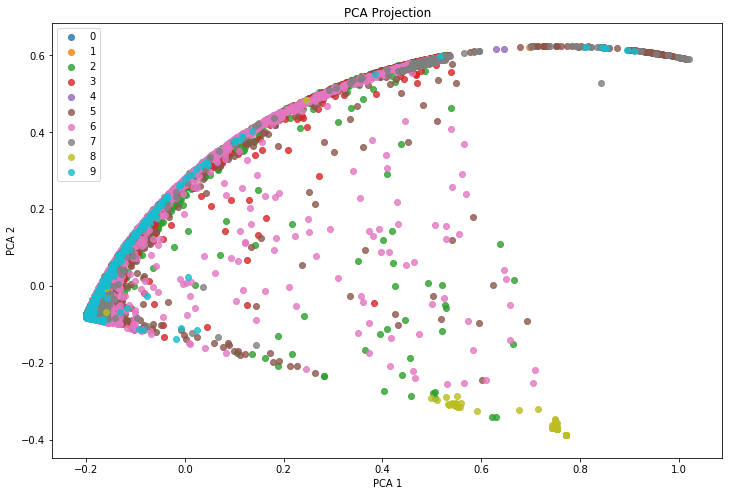

In [27]:
fig = plt.figure(figsize=(12, 8))

for lbl in np.unique(preProcLabels):
    plt.scatter(transfromFeat[preProcLabels == lbl, 0], transfromFeat[preProcLabels == lbl, 1],\
                alpha=.8, label='%i'%lbl)   

plt.title('PCA Projection')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

[ 0.56868185  0.28634483  0.05674083]


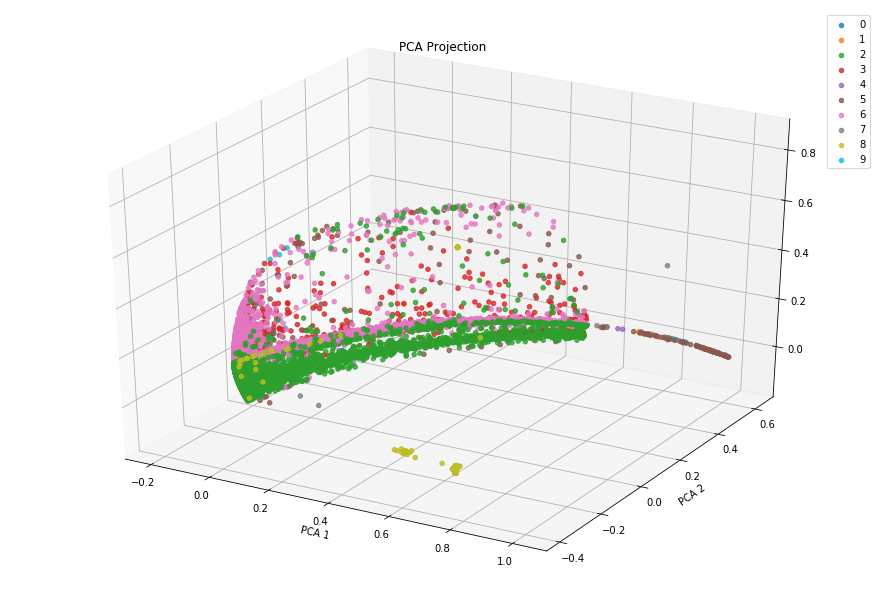

In [28]:
pca = PCA(n_components=3)
transfromFeat = pca.fit(normFeats).transform(normFeats)
print(pca.explained_variance_ratio_)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig)

for lbl in np.unique(preProcLabels):
    ax.scatter(transfromFeat[preProcLabels == lbl, 0], transfromFeat[preProcLabels == lbl, 1],\
                transfromFeat[preProcLabels == lbl, 2], alpha=.8, label='%i'%lbl)

plt.title('PCA Projection')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()